### Imports

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import category_encoders as ce

In [3]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
from sklearn.metrics import f1_score

In [6]:
from sklearn.model_selection import cross_val_score

In [7]:
from sklearn.model_selection import train_test_split

In [11]:
from sklearn import preprocessing

In [12]:
from datetime import datetime

In [8]:
from xgboost import XGBClassifier

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
from pprint import pprint

### Data preprocess functions

In [14]:
# function to convert strings and object types to number
def labelEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number 
    objectDataColumns = list(objectData)
    le = preprocessing.LabelEncoder()
    for column in objectDataColumns:
        objectData[column] = le.fit_transform(objectData[column])
    data.loc[objectData.index,objectData.columns] = objectData # merge to dataframe
    return data

In [15]:
# function to convert string to date time type for easy manipulation
def toDateTime(data, columns):
    for column in columns:
        date_data = data[column]
        date_data = date_data.fillna('0001-01-01 00:00:00') # str
        for i,items in date_data.iteritems():
            date_data[i] = datetime.strptime(items, '%Y-%m-%d %H:%M:%S')
        data.loc[date_data.index, date_data.name] = date_data # merge to dataframe
    return data

In [16]:
# merge similar date columns to fill missing values
def dateCorrMerge(data):
    checkDate = datetime(1, 1, 1) # value filled for NaN while converting to datetime 
    for ind in data.index: 
        if data['reported_date'][ind] == checkDate:
            if data['fire_start_date'][ind] != checkDate:
                data['reported_date'][ind] = data['fire_start_date'][ind]
            elif dateData['discovered_date'][ind] != checkDate:
                data['reported_date'][ind] = data['discovered_date'][ind]
            else:
                data['reported_date'][ind] = data['start_for_fire_date'][ind]
        if data['ex_fs_date'][ind] == checkDate:
            if data['uc_fs_date'][ind] != checkDate:
                data['ex_fs_date'][ind] = data['uc_fs_date'][ind]
            else:
                data['ex_fs_date'][ind] = data['bh_fs_date'][ind]
        if data['uc_fs_date'][ind] == checkDate:
            if data['ex_fs_date'][ind] != checkDate:
                data['uc_fs_date'][ind] = data['ex_fs_date'][ind]
            else:
                data['uc_fs_date'][ind] = data['uc_fs_date'][ind]
        if data['bh_fs_date'][ind] == checkDate:
            if data['start_for_fire_date'][ind] != checkDate:
                data['bh_fs_date'][ind] = data['start_for_fire_date'][ind]
            else:
                data['bh_fs_date'][ind] = data['discovered_date'][ind]
    data_processed = data.drop(['fire_start_date','discovered_date','start_for_fire_date'],axis = 1)
    return data_processed

In [17]:
# calc fire duration and month : substract extingush date from report date
def fireDurMonth(data):
    data_processed = data 
    data_processed['fire_duration'] = data['ex_fs_date'] - data['reported_date']
    data_processed['fire_duration2'] = data['uc_fs_date'] - data['bh_fs_date']
    data_processed['fire_duration3'] = data['ex_fs_date'] - data['uc_fs_date']
    data_processed['reported_month'] = data['reported_date']
    for ind in data_processed.index:
        data_processed['reported_month'][ind] = int(data_processed['reported_date'][ind].month)
        data_processed['fire_duration'][ind] = long(data_processed['fire_duration'][ind].total_seconds())
        data_processed['fire_duration2'][ind] = long(data_processed['fire_duration2'][ind].total_seconds())
        data_processed['fire_duration3'][ind] = long(data_processed['fire_duration3'][ind].total_seconds())
    data_processed = data_processed.drop(['ex_fs_date','reported_date','uc_fs_date','bh_fs_date'],axis = 1)
    return data_processed

In [18]:
# oneHot Encode : split text column into numerical columns
def oneHotEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number
    ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
    objectData = ohe.fit_transform(objectData)
    data = pd.merge(data, objectData, right_index=True, left_index=True)
    data = data.drop(columns,axis=1)
    return data

In [19]:
# data preprocess main function
def preprocess(data) :
    data_processed = data
    # first letter from fire_number : forest area in which the ignition area is located
    data_processed['fire_number'] = data_processed['fire_number'].astype(str).str[0]
    # remove unwanted columns
    data_processed = data_processed.drop(['fire_year','initial_action_by','fire_position_on_slope','assessment_datetime','fire_fighting_start_date','true_cause','det_agent_type','det_agent'],axis = 1)
    # make date format correct
    data_processed = toDateTime(data_processed,['fire_start_date','discovered_date','reported_date','start_for_fire_date','bh_fs_date','uc_fs_date','ex_fs_date'])
    # process the dates to calc month & duration of fire
    data_processed = dateCorrMerge(data_processed)
    data_processed = fireDurMonth(data_processed)
    # make data to numeric/seperate column
    # data_processed = oneHotEncode(data_processed,['general_cause_desc','fuel_type','fire_position_on_slope'])
    data_processed = labelEncode(data_processed,['general_cause_desc','fuel_type','fire_origin','fire_number','activity_class','fire_type','weather_conditions_over_fire'])
    return data_processed

### Data read

In [12]:
train_data = pd.read_csv('train.csv')

In [13]:
test_data_X = pd.read_csv('test.csv')

In [14]:
train_data_Y = train_data['size_class'] # column to be predicted 

In [15]:
train_data_X = train_data.drop(columns = "size_class")

### Preprocess

In [21]:
# train_data_X_processed = preprocess(train_data_X)

In [16]:
# save the processed data to csv (to save time)
# train_data_X_processed.to_csv('trainProcessed.csv',index=False)
# read already processed data
train_data_X_processed = pd.read_csv('trainProcessed.csv')

In [17]:
train_data_X_processed.dtypes

fire_number                       int64
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                       int64
general_cause_desc                int64
activity_class                    int64
fire_type                         int64
weather_conditions_over_fire      int64
fuel_type                         int64
fire_duration                     int64
fire_duration2                    int64
fire_duration3                    int64
reported_month                    int64
dtype: object

In [18]:
# data split

In [19]:
train_data_X, validate_data_X, train_data_Y, validate_data_Y = train_test_split(train_data_X_processed, train_data_Y, train_size=0.75, random_state=25)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Model training and tuning

In [20]:
# model = DecisionTreeClassifier(random_state=25)
# model = RandomForestClassifier(n_estimators=100, random_state=25)
model = XGBClassifier(random_state=25, n_estimators=150, max_depth=5)

Hyperparameter Tuning

In [21]:
# Parameters currently in use :
pprint(model.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 150,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 25,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


In [28]:
# A parameter grid for XGBoost
params_grid = {
        'base_score': [0.1, 0.2, 0.3],
        'min_child_weight': [0.9, 1],
        'gamma': [1, 1.2],
        'subsample': [0.5, 0.6],
        'colsample_bytree': [0.5, 0.6],
        'n_estimators': [120, 150, 170],
        'max_depth': [5]
        }

Random search

In [27]:
# Random search of parameters
random_search = RandomizedSearchCV(estimator=model, param_distributions=params_grid, n_iter=100, cv=3, verbose=2, random_state=25, n_jobs=-1)
# Fit the random search model
random_search.fit(train_data_X, train_data_Y)
# Best param after fitting
pprint(random_search.best_params_)
# Evaluate Random Search
model = random_search.best_estimator_
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.6min finished


{'base_score': 0.2,
 'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.6}
('Macro-F1 Score :', 0.5705578670132863, '(+/- 0.01)')


Grid search

In [29]:
# Grid search of parameters for model
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, verbose=2, n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(train_data_X, train_data_Y)
# Best param after fitting
pprint(grid_search.best_params_)
# Evaluate best grid search model
model = grid_search.best_estimator_
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 70.8min finished


{'base_score': 0.1,
 'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.5}
('Macro-F1 Score :', 0.5724732651062985, '(+/- 0.02)')


In [30]:
model.fit(train_data_X, train_data_Y)

XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=25,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

predict validation data

In [31]:
pred_validate_data_Y = model.predict(validate_data_X)

### Evaluation

In [32]:
print('Validation accuracy score:', accuracy_score(validate_data_Y, pred_validate_data_Y))

('Validation accuracy score:', 0.7792894935752078)


In [33]:
print('Macro F1-score:', f1_score(validate_data_Y, pred_validate_data_Y, average='macro'))

('Macro F1-score:', 0.5748024675708793)


Cross Validation

In [34]:
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

('Macro-F1 Score :', 0.5724732651062985, '(+/- 0.02)')


In [35]:
# re-train model on all train data

In [36]:
train_data_X = train_data_X_processed
train_data_Y = train_data['size_class'] # column to be predicted 

In [37]:
model.fit(train_data_X, train_data_Y)

XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=25,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

Feature importance

In [38]:
importance = pd.DataFrame()
importance['Feature'] = train_data_X.columns
importance['Importance'] = model.feature_importances_
importance.set_index('Feature', inplace=True)

importance.sort_values(by='Importance', ascending=False)

,Importance
Feature,
fuel_type,0.147971
fire_duration2,0.139350
fire_duration,0.118139
fire_duration3,0.094678
fire_type,0.078595
reported_month,0.075208
fire_origin,0.061157
activity_class,0.053573
general_cause_desc,0.052062


Confusion Matrix

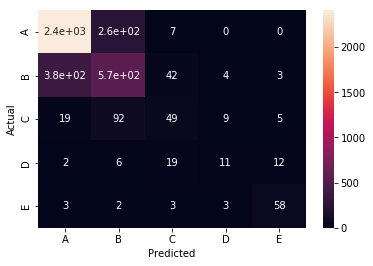

In [39]:
# Using seaborn: (plot_confusion_matrix has some version issues)
import seaborn as sn
confusion_matrix = pd.crosstab(validate_data_Y, pred_validate_data_Y, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

### Predict on Test dataset

In [40]:
pred_test_data_Y = pd.DataFrame()
pred_test_data_Y['fire_number'] = test_data_X['fire_number']

In [42]:
# test_data_X = preprocess(test_data_X)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

In [41]:
# save the processed data to csv (to save time)
# test_data_X.to_csv('testProcessed.csv',index=False)
# read already processed data
test_data_X = pd.read_csv('testProcessed.csv')

In [42]:
test_data_X.dtypes

fire_number                       int64
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                       int64
general_cause_desc                int64
activity_class                    int64
fire_type                         int64
weather_conditions_over_fire      int64
fuel_type                         int64
fire_duration                     int64
fire_duration2                    int64
fire_duration3                    int64
reported_month                    int64
dtype: object

In [43]:
pred_test_data_Y['size_class'] = model.predict(test_data_X)

In [44]:
pred_test_data_Y.shape

(3969, 2)